First, we will define image matching pipeline with OpenCV SIFT features. We will also use kornia for the state-of-the-art match filtering -- Lowe ratio + mutual nearest neighbor check and [MAGSAC++](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/05/17/OpenCV-New-RANSACs.html) as RANSAC.

In [56]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

In [57]:
%%capture
# fname1 = "input_photos/temp5.png"
# fname2 = "input_photos/temp7.png"

fname1 = "input_photos/c1-new.png"
fname2 = "input_photos/crop.png"

img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (600, 375), antialias=True)
img2 = K.geometry.resize(img2, (600, 375), antialias=True)


matcher = KF.LoFTR(pretrained="outdoor")

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    "image1": K.color.rgb_to_grayscale(img2),
}

with torch.inference_mode():
    correspondences = matcher(input_dict)

In [58]:
for k, v in correspondences.items():
    print(k)

keypoints0
keypoints1
confidence
batch_indexes


Now let's clean-up the correspondences with modern RANSAC and estimate fundamental matrix between two images

In [59]:
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

Finally, let's draw the matches with a function from [kornia_moons](https://ducha-aiki.github.io/kornia_moons/feature.html#draw_LAF_matches). The correct matches are in green and imprecise matches - in blue

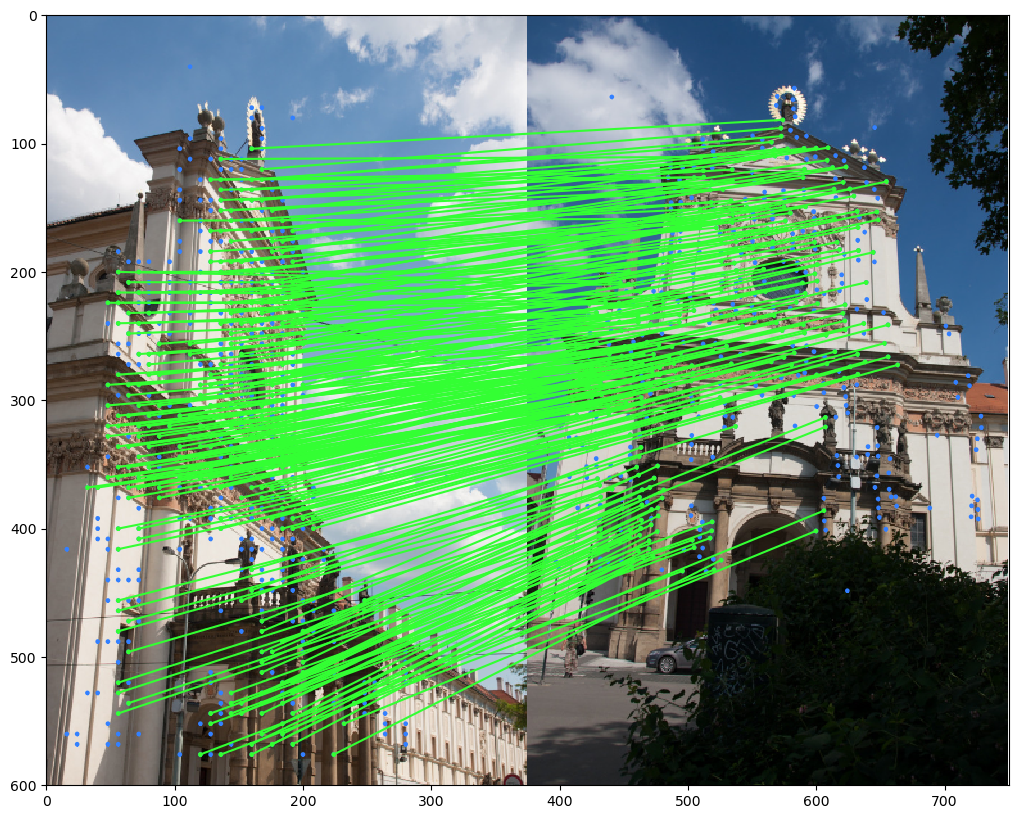

In [60]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": (0.2, 0.5, 1), "vertical": False},
)